Epoch 1/5
49/49 [==============================] - 246s 5s/step - loss: 2.1135 - sparse_categorical_accuracy: 0.2057 - val_loss: 1.8840 - val_sparse_categorical_accuracy: 0.3099
Epoch 2/5
49/49 [==============================] - 248s 5s/step - loss: 1.8277 - sparse_categorical_accuracy: 0.3209 - val_loss: 1.7626 - val_sparse_categorical_accuracy: 0.3490
Epoch 3/5
49/49 [==============================] - 251s 5s/step - loss: 1.7074 - sparse_categorical_accuracy: 0.3619 - val_loss: 1.6590 - val_sparse_categorical_accuracy: 0.3764
Epoch 4/5
49/49 [==============================] - 251s 5s/step - loss: 1.6284 - sparse_categorical_accuracy: 0.3934 - val_loss: 1.5704 - val_sparse_categorical_accuracy: 0.4114
Epoch 5/5
49/49 [==============================] - 252s 5s/step - loss: 1.5511 - sparse_categorical_accuracy: 0.4260 - val_loss: 1.5184 - val_sparse_categorical_accuracy: 0.4391
Model: "inception10_1"
_________________________________________________________________
Layer (type)         

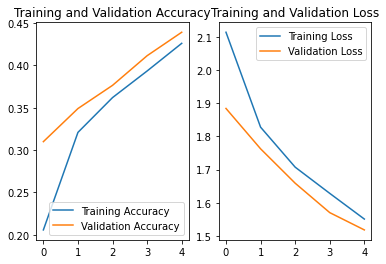

In [11]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization,Activation, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

np.set_printoptions(threshold=np.inf)

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


class ConvBNRelu(Model):
    def __init__(self, ch, kernelsz=3, strides=1, padding='same'):
        super(ConvBNRelu, self).__init__()
        self.model = tf.keras.models.Sequential([
            Conv2D(ch, kernelsz, strides=strides, padding=padding),
            BatchNormalization(),
            Activation('relu')
        ])

    def call(self, x):
        x = self.model(x, training=False) #在training=False时，BN通过整个训练集计算均值、方差去做批归一化，training=True时，通过当前batch的均值、方差去做批归一化。推理时 training=False效果好
        return x


class InceptionBlk(Model):
    def __init__(self, ch, strides=1):
        super(InceptionBlk, self).__init__()
        self.ch = ch
        self.strides = strides
        self.c1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c2_1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c2_2 = ConvBNRelu(ch, kernelsz=3, strides=1)
        self.c3_1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.c3_2 = ConvBNRelu(ch, kernelsz=5, strides=1)
        self.p4_1 = MaxPool2D(3, strides=1, padding='same')
        self.c4_2 = ConvBNRelu(ch, kernelsz=1, strides=strides)

    def call(self, x):
        x1 = self.c1(x)
        x2_1 = self.c2_1(x)
        x2_2 = self.c2_2(x2_1)
        x3_1 = self.c3_1(x)
        x3_2 = self.c3_2(x3_1)
        x4_1 = self.p4_1(x)
        x4_2 = self.c4_2(x4_1)
        # concat along axis=channel
        x = tf.concat([x1, x2_2, x3_2, x4_2], axis=3)
        return x


class Inception10(Model):
    def __init__(self, num_blocks, num_classes, init_ch=16, **kwargs):
        super(Inception10, self).__init__(**kwargs)
        self.in_channels = init_ch
        self.out_channels = init_ch
        self.num_blocks = num_blocks
        self.init_ch = init_ch
        self.c1 = ConvBNRelu(init_ch)
        self.blocks = tf.keras.models.Sequential()
        for block_id in range(num_blocks):
            for layer_id in range(2):
                if layer_id == 0:
                    block = InceptionBlk(self.out_channels, strides=2)
                else:
                    block = InceptionBlk(self.out_channels, strides=1)
                self.blocks.add(block)
            # enlarger out_channels per block
            self.out_channels *= 2
        self.p1 = GlobalAveragePooling2D()
        self.f1 = Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.blocks(x)
        x = self.p1(x)
        y = self.f1(x)
        return y


model = Inception10(num_blocks=2, num_classes=10)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/Inception10.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=1024, epochs=5, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])
model.summary()

# print(model.trainable_variables)
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

###############################################    show   ###############################################

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
